### C12 simulator
The C12 simulator is made on top of the Qiskit library with a noise model corresponding to our system integrated to simulate the real machine currently in development.

To run the circuits on the C12 simulator, first, it is mandatory to obtain the authentication token that will be used for connection to the remote server where our simulator is. So don't hesitate to contact the system administrator to get one.

A token is set via UserConfig class, as shown in the example bellow. UserConfig class has other properties, like more detailed out, which can be set by setting the parameter "verbose" to True. One important remark is that the object of the `UserConfig` class is passed to the provider instance, so for any changed to take effect one has to reinitialize the provider.


In [2]:
# Installing the c12simulator-clients package (for more details see jupyter 1)
!python -m pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple c12simulator-clients==0.0.28 -q

As mentioned in the first tutorial, the provided class contains information about available backends that can be used for running the circuit. Furthermore, the available ones can be viewed using the `backends()` method of the provider class (recall that this applies to every Qiskit's provider class, as its sole purpose is to provide access to backends).



In [10]:
# UserConfig class
from c12simulator_clients.user_configs import UserConfigs
user_auth_token = "db0ccae9b0dfccba90a534ad40802d40aa57d395bdac4e3a0bfcaaa7db0a3c2f"
configs = UserConfigs.parse_obj({"token" : user_auth_token})

from c12simulator_clients.qiskit_back.c12sim_provider import C12SimProvider
c12_simulator_provider = C12SimProvider(configs)
c12_backends = c12_simulator_provider.backends()

print(f'C12 simulator: {c12_backends[0]}')

C12 simulator: {'backend_name': 'c12sim', 'local': False, 'simulator': True, 'basis_gates': ['crx', 'rx', 'ry', 'rz'], 'description': 'C12 simulator', 'n_qubits': 5, 'conditional': False, 'max_shots': 100000, 'memory': False, 'open_pulse': False, 'max-circuits': 1}


We have to call the `get_backend()` function to get the instance of a chosen backend. To the `get_backend()` function, we pass the name of the desired backend we need to obtain.

In [11]:
c12_simulator_backend = c12_simulator_provider.get_backend('c12sim')
print(c12_simulator_backend)

Finally, we will run a quantum circuit on the C12 simulator. We will create one circuit using the Qiskit QuantumCircuit class to do that. Then, using the obtained C12 simulator backend class, we will run the circuit using the `run()` method.

Method `run()` can have an additional parameter, such as the number of shots (number of times the simulation is run)
Also, recall that after calling the `run()` method, we get an instance of a Job class.
Additionally, it could take some time for the simulation to finish. Usually, the time is less than one minute, but it depends on the circuit and the server load at that moment.

In [12]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)
circuit.h(0)
circuit.cx(0, 1)

c12_job = c12_simulator_backend.run(circuit, shots=10000)
c12_result = c12_job.result()
c12_counts = c12_result.get_counts()
print(f"C12 simulation counts: {c12_counts}")

C12 simulation counts: {'01 ': 7, '10 ': 10, '00 ': 4974, '11 ': 5009}


In [13]:
# We will also run the same circuit on the Aer statevector simulator to obtain the perfect results.
from qiskit import Aer

backend_aer = Aer.get_backend("statevector_simulator")
result_aer = backend_aer.run(circuit, shots=10000).result()
counts_aer = result_aer.get_counts()

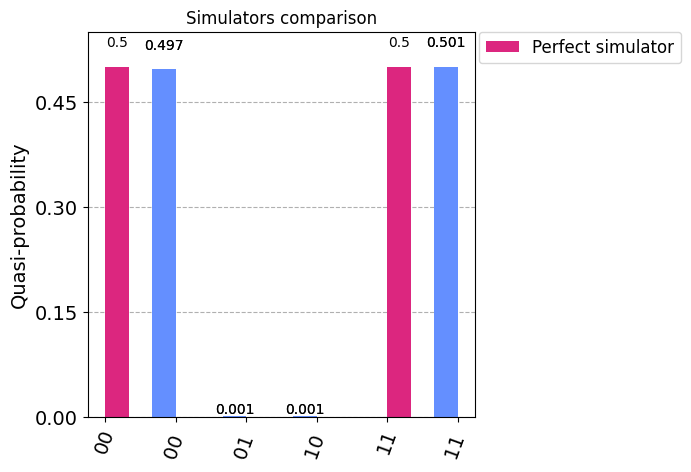

In [14]:
# Make comparison
from qiskit.visualization import plot_histogram
data = [c12_counts, counts_aer]
plot_histogram(data,
               legend=['C12 simulator', 'Perfect simulator'],
               title="Simulators comparison",
               figsize=(5, 5))

#### Groover algorithm example

The Grover algorithm, also known as Grover's search algorithm, is a quantum algorithm that can be used to search an unsorted database or find a specific database entry faster than classical algorithms. It is one of the youngest quantum algorithms.

The algorithm works by starting with a superposition of all possible states and then applying a series of operations to amplify the amplitude of the state corresponding to the desired item. As a result, the algorithm achieves a quadratic speedup over classical algorithms, which means that it can search a database of N items in O($\sqrt{N}$) time, compared to O(N) time for classical algorithms.

First, we will create an groover circuit with a two qubits.

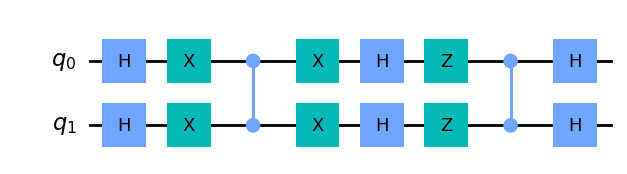

In [15]:
from qiskit import QuantumRegister

qreg_q = QuantumRegister(2, 'q')
groover_circuit = QuantumCircuit(qreg_q)

groover_circuit.h(qreg_q[1])
groover_circuit.h(qreg_q[0])
groover_circuit.x(qreg_q[1])
groover_circuit.x(qreg_q[0])
groover_circuit.cz(qreg_q[0], qreg_q[1])
groover_circuit.x(qreg_q[0])
groover_circuit.x(qreg_q[1])
groover_circuit.h(qreg_q[0])
groover_circuit.h(qreg_q[1])
groover_circuit.z(qreg_q[0])
groover_circuit.z(qreg_q[1])
groover_circuit.cz(qreg_q[0], qreg_q[1])
groover_circuit.h(qreg_q[0])
groover_circuit.h(qreg_q[1])

groover_circuit.draw('mpl')

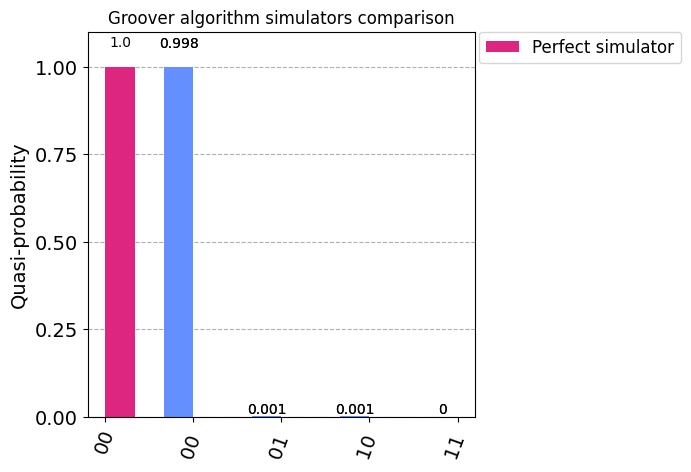

In [16]:
# Run the circuit on C12 simulator
c12_groover_result = c12_simulator_backend.run(groover_circuit, shots=10000).result()
c12_groover_counts = c12_groover_result.get_counts()

aer_groover_result = backend_aer.run(groover_circuit, shots=10000).result()
aer_groover_counts = aer_groover_result.get_counts()

data = [c12_groover_counts, aer_groover_counts]
plot_histogram(data, legend=['C12 simulator', 'Perfect simulator'], title="Groover algorithm simulators comparison", figsize=(5,5))